In [5]:
!python -c "import torch.utils"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/__init__.py", line 5, in <module>
    from .throughput_benchmark import ThroughputBenchmark
  File "/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/torch/utils/throughput_benchmark.py", line 3, in <module>
    import torch._C
ModuleNotFoundError: No module named 'torch._C'


In [9]:
%pip install --force-reinstall torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl (797.1 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [19]:
%pip install plothelp

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import random, os

from cloudcasting.dataset import SatelliteDataset


def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.mps.manual_seed(seed)
    
seed_everything(42)

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
from diffusers import DDPMScheduler, UNet2DModel
from cloudcasting.constants import NUM_CHANNELS


class ConditionedUnet(nn.Module):
    history_steps: int
    def __init__(self, image_size, history_steps = 1):
        super().__init__()

        self.history_steps = history_steps

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (previous timesteps)
        self.model = UNet2DModel(
            sample_size=image_size,  # the target image resolution
            in_channels=NUM_CHANNELS + history_steps * NUM_CHANNELS,  # noise input + conditioning information
            out_channels=NUM_CHANNELS,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(
                128, 
                256, 
                # 512,
            ),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                # "DownBlock2D",  # a regular ResNet downsampling block

                # "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                # "AttnDownBlock2D",
            ),
            up_block_types=(
                # "AttnUpBlock2D",
                # "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
                "UpBlock2D",  # a regular ResNet upsampling block
                # "UpBlock2D",  # a regular ResNet upsampling block
            ),
            add_attention = False,  # blows up memory with attention -- maybe do latent diffusion
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, noisy_image, conditioning, t):

        # stack noisy image and conditioning info along the time axis
        stacked = torch.cat([noisy_image, conditioning], dim=-3) 
        # print(f"{stacked.shape=}")

        # reshape to (batch, channels*time, height, width)
        net_input = stacked.reshape(-1, stacked.shape[-4] * stacked.shape[-3], *stacked.shape[-2:])

        return self.model(net_input, t).sample
    


/bask/homes/g/gmmg6904/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from cloudcasting.constants import DATA_INTERVAL_SPACING_MINUTES

TRAINING_DATA_PATH = "/bask/projects/v/vjgo8416-climate/shared/data/eumetsat/training/2022_training_nonhrv.zarr"
HISTORY_STEPS = 1

# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path=TRAINING_DATA_PATH,
    start_time=None,
    end_time=None,
    history_mins=(HISTORY_STEPS - 1) * DATA_INTERVAL_SPACING_MINUTES,
    forecast_mins=15,
    sample_freq_mins=15,
    nan_to_num=True,
)

In [5]:
# Number of complete samples in the dataset
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

# nan percentage
# print(f"NaN percentage: {np.mean(np.isnan(dataset.ds)).compute()}")

13826


In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

batch_size = 2
num_workers = 0

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

# train_dataloader = DataLoader(
#     dataset=dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
# )


In [7]:
X, y = next(iter(train_dataloader))

assert X.shape == y.shape

In [8]:
# Instantiate the model
# Calculate required crop for the input dims to be divisible by 16
x_cropped_shape = [(size // 16) * 16 for size in X.shape[-2:]]
model = ConditionedUnet(x_cropped_shape, history_steps=HISTORY_STEPS).to(device)

In [9]:

def crop(x):
    # Calculate required crop for the input dims to be divisible by 16
    x_cropped_shape = [(size // 16) * 16 for size in x.shape[-2:]]
    return x[..., :x_cropped_shape[0], :x_cropped_shape[1]]

In [10]:
# example sample
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Get some data and prepare the corrupted version
X = crop(X.to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)

y = crop(y.to(device) * 2 - 1)
noise = torch.randn_like(y)  # base noise on the target image
timesteps = torch.randint(0, 999, (X.shape[0],)).long().to(device)
noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y
# Predict the noise based on previous images and the noisy forecast target
pred = model(noisy_y, X, timesteps).reshape(y.shape)[0]
print(f"{pred.shape=}")

pred.shape=torch.Size([11, 1, 368, 608])


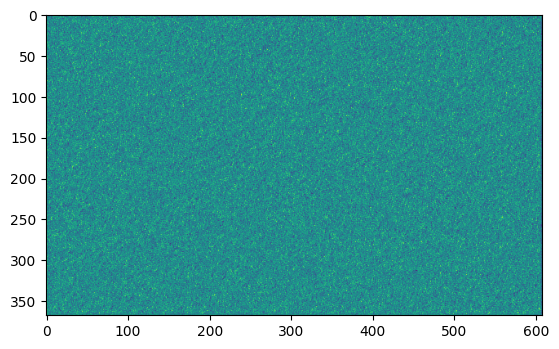

In [19]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

ax.imshow(pred[1].to("cpu").squeeze().detach().numpy())

In [18]:
from tqdm import tqdm
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

model = model.to(device) # model on device

# How many runs through the data should we do?
n_epochs = 1

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []
best_loss = 999
best_model = None



# The training loop
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(tqdm(train_dataloader)):

        # Get some data and prepare the corrupted version
        x = crop(x.to(device) * 2 - 1)  # Data on the GPU (mapped to (-1, 1)) (????)
        
        y = crop(y.to(device) * 2 - 1)
        # Calculate required crop for the input dims to be divisible by 16
        y_cropped_shape = [(size // 16) * 16 for size in y.shape[-2:]]
        y_cropped = y[..., :y_cropped_shape[0], :y_cropped_shape[1]]
        noise = torch.randn_like(y)  # base noise on the target image
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)  # Note that we pass in the target y

        # Predict the noise based on previous images and the noisy forecast target
        pred = model(noisy_y, x, timesteps).reshape(y.shape)

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        print(f"Loss: {loss.item():05f}")
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")
    
    tor

# View the loss curve
plt.plot(losses)

  0%|          | 1/6913 [00:00<57:00,  2.02it/s]

Loss: 1.136259


  0%|          | 2/6913 [00:00<55:50,  2.06it/s]

Loss: 1.329357


  0%|          | 3/6913 [00:01<55:24,  2.08it/s]

Loss: 1.095857


  0%|          | 4/6913 [00:01<55:13,  2.09it/s]

Loss: 1.012453


  0%|          | 5/6913 [00:02<55:05,  2.09it/s]

Loss: 1.022757


  0%|          | 6/6913 [00:02<55:01,  2.09it/s]

Loss: 1.021459


  0%|          | 7/6913 [00:03<54:58,  2.09it/s]

Loss: 1.020097


  0%|          | 8/6913 [00:03<54:54,  2.10it/s]

Loss: 0.992582


  0%|          | 9/6913 [00:04<54:51,  2.10it/s]

Loss: 0.986022


  0%|          | 10/6913 [00:04<54:52,  2.10it/s]

Loss: 1.002483


  0%|          | 11/6913 [00:05<54:47,  2.10it/s]

Loss: 0.983964


  0%|          | 12/6913 [00:05<54:46,  2.10it/s]

Loss: 0.983301


  0%|          | 13/6913 [00:06<54:53,  2.09it/s]

Loss: 1.012427


  0%|          | 14/6913 [00:06<54:50,  2.10it/s]

Loss: 1.020943


  0%|          | 15/6913 [00:07<54:53,  2.09it/s]

Loss: 1.042369


  0%|          | 16/6913 [00:07<54:53,  2.09it/s]

Loss: 1.045388


  0%|          | 17/6913 [00:08<54:52,  2.09it/s]

Loss: 1.006369


  0%|          | 18/6913 [00:08<54:49,  2.10it/s]

Loss: 1.015493


  0%|          | 19/6913 [00:09<54:50,  2.09it/s]

Loss: 1.014753


  0%|          | 20/6913 [00:09<54:44,  2.10it/s]

Loss: 1.019577


  0%|          | 21/6913 [00:10<54:46,  2.10it/s]

Loss: 1.015136


  0%|          | 22/6913 [00:10<54:47,  2.10it/s]

Loss: 1.004725


  0%|          | 23/6913 [00:10<54:40,  2.10it/s]

Loss: 1.002114


  0%|          | 24/6913 [00:11<54:46,  2.10it/s]

Loss: 1.009952


  0%|          | 25/6913 [00:11<54:43,  2.10it/s]

Loss: 1.012656


  0%|          | 26/6913 [00:12<54:45,  2.10it/s]

Loss: 1.005245


  0%|          | 27/6913 [00:12<54:46,  2.10it/s]

Loss: 1.001140


  0%|          | 28/6913 [00:13<54:46,  2.09it/s]

Loss: 1.002242


  0%|          | 29/6913 [00:13<54:44,  2.10it/s]

Loss: 1.005900


  0%|          | 30/6913 [00:14<54:46,  2.09it/s]

Loss: 1.006085


  0%|          | 31/6913 [00:14<54:47,  2.09it/s]

Loss: 1.003773


  0%|          | 32/6913 [00:15<54:45,  2.09it/s]

Loss: 1.000709


  0%|          | 33/6913 [00:15<54:46,  2.09it/s]

Loss: 1.001040


  0%|          | 34/6913 [00:16<54:44,  2.09it/s]

Loss: 1.002790


  1%|          | 35/6913 [00:16<54:44,  2.09it/s]

Loss: 1.003772


  1%|          | 36/6913 [00:17<54:42,  2.10it/s]

Loss: 1.003374


  1%|          | 37/6913 [00:17<54:43,  2.09it/s]

Loss: 1.001983


  1%|          | 38/6913 [00:18<54:42,  2.09it/s]

Loss: 1.001117


  1%|          | 39/6913 [00:18<54:48,  2.09it/s]

Loss: 1.000893


  1%|          | 40/6913 [00:19<54:39,  2.10it/s]

Loss: 1.001706


  1%|          | 41/6913 [00:19<54:37,  2.10it/s]

Loss: 1.000121


  1%|          | 42/6913 [00:20<54:37,  2.10it/s]

Loss: 1.001621


  1%|          | 43/6913 [00:20<54:31,  2.10it/s]

Loss: 0.999565


  1%|          | 44/6913 [00:21<54:35,  2.10it/s]

Loss: 0.999872


  1%|          | 45/6913 [00:21<54:36,  2.10it/s]

Loss: 1.000525


  1%|          | 46/6913 [00:21<54:44,  2.09it/s]

Loss: 0.999848


  1%|          | 47/6913 [00:22<54:41,  2.09it/s]

Loss: 1.001728


  1%|          | 48/6913 [00:22<54:37,  2.09it/s]

Loss: 1.000353


  1%|          | 49/6913 [00:23<54:31,  2.10it/s]

Loss: 0.998897


  1%|          | 50/6913 [00:23<54:32,  2.10it/s]

Loss: 0.998415


  1%|          | 51/6913 [00:24<54:33,  2.10it/s]

Loss: 0.999544


  1%|          | 52/6913 [00:24<54:31,  2.10it/s]

Loss: 1.000293


  1%|          | 53/6913 [00:25<54:31,  2.10it/s]

Loss: 0.998256


  1%|          | 54/6913 [00:25<54:33,  2.10it/s]

Loss: 0.997725


  1%|          | 55/6913 [00:26<54:33,  2.10it/s]

Loss: 0.998607


  1%|          | 56/6913 [00:26<54:41,  2.09it/s]

Loss: 0.998420


  1%|          | 57/6913 [00:27<54:36,  2.09it/s]

Loss: 1.000687


  1%|          | 58/6913 [00:27<54:33,  2.09it/s]

Loss: 1.003779


  1%|          | 59/6913 [00:28<54:30,  2.10it/s]

Loss: 1.000647


  1%|          | 60/6913 [00:28<54:27,  2.10it/s]

Loss: 1.001685


  1%|          | 61/6913 [00:29<54:29,  2.10it/s]

Loss: 1.003135


  1%|          | 62/6913 [00:29<54:27,  2.10it/s]

Loss: 1.000840


  1%|          | 63/6913 [00:30<54:29,  2.10it/s]

Loss: 1.000892


  1%|          | 64/6913 [00:30<54:26,  2.10it/s]

Loss: 1.001500


  1%|          | 65/6913 [00:31<54:30,  2.09it/s]

Loss: 1.000393


  1%|          | 66/6913 [00:31<54:30,  2.09it/s]

Loss: 1.001393


  1%|          | 67/6913 [00:31<54:38,  2.09it/s]

Loss: 1.000684


  1%|          | 68/6913 [00:32<54:34,  2.09it/s]

Loss: 1.001495


  1%|          | 69/6913 [00:32<54:32,  2.09it/s]

Loss: 1.002382


  1%|          | 70/6913 [00:33<54:28,  2.09it/s]

Loss: 0.999519


  1%|          | 71/6913 [00:33<54:28,  2.09it/s]

Loss: 1.001196


  1%|          | 72/6913 [00:34<54:54,  2.08it/s]

Loss: 1.000123


  1%|          | 73/6913 [00:34<54:46,  2.08it/s]

Loss: 1.000663


  1%|          | 74/6913 [00:35<54:39,  2.09it/s]

Loss: 1.001040


  1%|          | 75/6913 [00:35<54:34,  2.09it/s]

Loss: 1.000981


  1%|          | 76/6913 [00:36<54:35,  2.09it/s]

Loss: 1.000013


  1%|          | 77/6913 [00:36<54:36,  2.09it/s]

Loss: 0.999463


  1%|          | 78/6913 [00:37<54:32,  2.09it/s]

Loss: 0.998735


  1%|          | 79/6913 [00:37<54:36,  2.09it/s]

Loss: 0.999292


  1%|          | 80/6913 [00:38<54:35,  2.09it/s]

Loss: 1.000260


  1%|          | 81/6913 [00:38<54:33,  2.09it/s]

Loss: 0.999957


  1%|          | 82/6913 [00:39<54:33,  2.09it/s]

Loss: 0.999814


  1%|          | 83/6913 [00:39<54:26,  2.09it/s]

Loss: 0.999679


  1%|          | 84/6913 [00:40<54:29,  2.09it/s]

Loss: 1.000013


  1%|          | 85/6913 [00:40<54:25,  2.09it/s]

Loss: 1.001064


  1%|          | 86/6913 [00:41<54:22,  2.09it/s]

Loss: 1.000083


  1%|▏         | 87/6913 [00:41<54:19,  2.09it/s]

Loss: 0.999761


  1%|▏         | 88/6913 [00:42<54:19,  2.09it/s]

Loss: 1.000727


  1%|▏         | 89/6913 [00:42<54:17,  2.09it/s]

Loss: 0.999423


  1%|▏         | 90/6913 [00:43<54:19,  2.09it/s]

Loss: 0.999803


  1%|▏         | 91/6913 [00:43<54:21,  2.09it/s]

Loss: 0.999308


  1%|▏         | 92/6913 [00:43<54:17,  2.09it/s]

Loss: 1.000274


  1%|▏         | 93/6913 [00:44<54:14,  2.10it/s]

Loss: 0.999408


  1%|▏         | 94/6913 [00:44<54:13,  2.10it/s]

Loss: 0.999933


  1%|▏         | 95/6913 [00:45<54:07,  2.10it/s]

Loss: 1.000046


  1%|▏         | 96/6913 [00:45<54:20,  2.09it/s]

Loss: 1.000980


  1%|▏         | 97/6913 [00:46<54:18,  2.09it/s]

Loss: 0.999335


  1%|▏         | 98/6913 [00:46<54:14,  2.09it/s]

Loss: 1.000624


  1%|▏         | 99/6913 [00:47<54:15,  2.09it/s]

Loss: 1.000766


  1%|▏         | 100/6913 [00:47<54:15,  2.09it/s]

Loss: 0.999325


  1%|▏         | 101/6913 [00:48<54:13,  2.09it/s]

Loss: 1.000289


  1%|▏         | 102/6913 [00:48<54:22,  2.09it/s]

Loss: 0.999437


  1%|▏         | 103/6913 [00:49<54:17,  2.09it/s]

Loss: 0.999651


  2%|▏         | 104/6913 [00:49<54:20,  2.09it/s]

Loss: 0.999566


  2%|▏         | 105/6913 [00:50<54:17,  2.09it/s]

Loss: 0.999907


  2%|▏         | 106/6913 [00:50<54:21,  2.09it/s]

Loss: 1.000628


  2%|▏         | 107/6913 [00:51<54:12,  2.09it/s]

Loss: 1.000217


  2%|▏         | 108/6913 [00:51<54:17,  2.09it/s]

Loss: 0.999088


  2%|▏         | 109/6913 [00:52<54:16,  2.09it/s]

Loss: 1.000764


  2%|▏         | 110/6913 [00:52<54:18,  2.09it/s]

Loss: 0.999718


  2%|▏         | 111/6913 [00:53<54:16,  2.09it/s]

Loss: 0.999290


  2%|▏         | 112/6913 [00:53<54:16,  2.09it/s]

Loss: 1.000538


  2%|▏         | 113/6913 [00:54<55:09,  2.05it/s]

Loss: 0.998796


  2%|▏         | 114/6913 [00:54<54:54,  2.06it/s]

Loss: 0.999776


  2%|▏         | 115/6913 [00:54<54:47,  2.07it/s]

Loss: 0.999423


  2%|▏         | 116/6913 [00:55<54:36,  2.07it/s]

Loss: 0.999745


  2%|▏         | 117/6913 [00:55<54:35,  2.07it/s]

Loss: 0.999658


  2%|▏         | 118/6913 [00:56<54:25,  2.08it/s]

Loss: 0.999781


  2%|▏         | 119/6913 [00:56<54:39,  2.07it/s]

Loss: 0.999494


  2%|▏         | 120/6913 [00:57<54:37,  2.07it/s]

Loss: 0.999579


  2%|▏         | 121/6913 [00:57<54:56,  2.06it/s]

Loss: 1.000055


  2%|▏         | 122/6913 [00:58<54:56,  2.06it/s]

Loss: 0.999794


  2%|▏         | 123/6913 [00:58<54:44,  2.07it/s]

Loss: 0.999227


  2%|▏         | 124/6913 [00:59<54:37,  2.07it/s]

Loss: 0.999121


  2%|▏         | 124/6913 [00:59<54:34,  2.07it/s]


KeyboardInterrupt: 

In [9]:
losses

[1.1553138494491577]